(1000, 2)


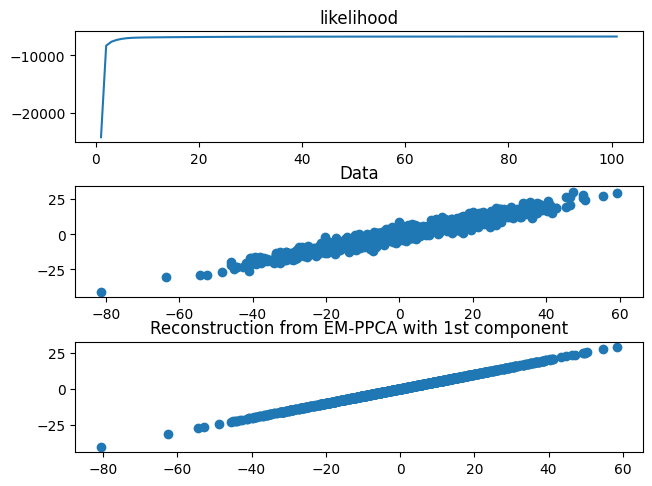

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

k = 1
tol = 1e-5

# MANUAL

def get_llh(X,Lambda,Psi):
    Sigma = np.matmul(Lambda.T,Lambda) + Psi
    mu = np.zeros(np.shape(X)[1])
    return np.sum(multivariate_normal.logpdf(X,mu,Sigma))


def expectation(X,Lambda,Psi):
    invPsi =np.linalg.inv(Psi)
    A = np.matmul(Lambda,np.matmul(invPsi,Lambda.T))
    G = np.linalg.inv(np.eye(k)+A)
    g = np.matmul(G,np.matmul(Lambda,np.matmul(invPsi,X.T)))  ## could be G.T instead of G
    return g,G

def maximization(X,g,G):
    N = np.shape(X)[0]
    invgsq = np.linalg.inv(np.matmul(g,g.T) + N*G)
    Lambda = np.matmul(X.T,np.matmul(g.T,invgsq)).T
    LambdaSq = np.matmul(Lambda,Lambda.T)
    s = 0
    for i in range(N):
        s0 = np.linalg.norm(X[i,:])**2
        s1 = 2*np.dot(g[:,i],np.matmul(Lambda,X[i,:]))
        s2 = np.trace(np.matmul(np.outer(g[:,i],g[:,i])+G,LambdaSq.T))
        s+= s0 - s1 + s2
    sigma = s/(np.prod(np.shape(X)))
    return Lambda,sigma


## generate artificial data
numSamp = 1000
Lambda_true = np.array([20,10]).reshape((2,1))
sigma_true = 5
Psi = sigma_true*np.eye(2)
X0 = np.matmul(Lambda_true,np.random.normal(size=(1,numSamp)))
X1 = np.matmul(np.sqrt(Psi),np.random.normal(size=(2,numSamp)))
X = (X0+X1).T



## initialization and preprocessing
Lambda = 0.1*np.random.normal(size=(k,np.shape(X)[1]))
sigma = 0.1
Psi = sigma*np.eye(np.shape(X)[1])
mu = np.mean(X,0)
X = X-mu



# iteration
llh = [-np.inf]
for i in range(500):
    g,G = expectation(X,Lambda,Psi)
    Lambda, sigma = maximization(X,g,G)
    Psi = sigma*np.eye(np.shape(X)[1])
    llh.append(get_llh(X,Lambda,Psi))
    if abs(llh[i]-llh[i+1]) < tol*abs(llh[i+1]):
        break


Xpred = np.matmul(Lambda.T,g).T
print(np.shape(Xpred))

fig, ax = plt.subplots(3,1)
fig.tight_layout()
ax[0].set_title('likelihood')
ax[0].plot(range(len(llh)),llh)
ax[1].set_title('Data')
ax[1].scatter(X[:,0],X[:,1])
ax[2].set_title('Reconstruction from EM-PPCA with 1st component')
ax[2].scatter(Xpred[:,0],Xpred[:,1])
plt.show()



